# Writing ResNet from Scratch in PyTorch


In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def data_loader(data_dir,
                    batch_size,
                    random_seed=42,
                    valid_size=0.1,
                    shuffle=True,
                    test=False):

        normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )

        # define transforms
        transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                normalize,
        ])

        if test:
            dataset = datasets.CIFAR10(
              root=data_dir, train=False,
              download=True, transform=transform,
            )

            data_loader = torch.utils.data.DataLoader(
                dataset, batch_size=batch_size, shuffle=shuffle
            )

            return data_loader

        # load the dataset
        train_dataset = datasets.CIFAR10(
            root=data_dir, train=True,
            download=True, transform=transform,
        )

        valid_dataset = datasets.CIFAR10(
            root=data_dir, train=True,
            download=True, transform=transform,
        )

        num_train = len(train_dataset)
        indices = list(range(num_train))
        split = int(np.floor(valid_size * num_train))

        if shuffle:
            np.random.seed(42)
            np.random.shuffle(indices)

        train_idx, valid_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=train_sampler)

        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=batch_size, sampler=valid_sampler)

        return (train_loader, valid_loader)
train_loader, valid_loader = data_loader(data_dir='./data',
                                             batch_size=64)

test_loader = data_loader(data_dir='./data',
                                  batch_size=64,
                                  test=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
            super(ResidualBlock, self).__init__()
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())
            self.conv2 = nn.Sequential(
                            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                            nn.BatchNorm2d(out_channels))
            self.downsample = downsample
            self.relu = nn.ReLU()
            self.out_channels = out_channels

        def forward(self, x):
            residual = x
            out = self.conv1(x)
            out = self.conv2(out)
            if self.downsample:
                residual = self.downsample(x)
            out += residual
            out = self.relu(out)
            return out

In [4]:
class ResNet(nn.Module):
        def __init__(self, block, layers, num_classes = 10):
            super(ResNet, self).__init__()
            self.inplanes = 64
            self.conv1 = nn.Sequential(
                            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                            nn.BatchNorm2d(64),
                            nn.ReLU())
            self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
            self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
            self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
            self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
            self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
            self.avgpool = nn.AvgPool2d(7, stride=1)
            self.fc = nn.Linear(512, num_classes)

        def _make_layer(self, block, planes, blocks, stride=1):
            downsample = None
            if stride != 1 or self.inplanes != planes:

                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(planes),
                )
            layers = []
            layers.append(block(self.inplanes, planes, stride, downsample))
            self.inplanes = planes
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)

        def forward(self, x):
            x = self.conv1(x)
            x = self.maxpool(x)
            x = self.layer0(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)

            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)

            return x

In [5]:
num_classes = 10
num_epochs = 20
batch_size = 16
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

#Train the model
total_step = len(train_loader)

In [7]:
#save model
torch.save(model.state_dict(), "best_resnet_model.pth")


In [8]:
#load model
model.load_state_dict(torch.load("best_resnet_model.pth"))


<All keys matched successfully>

In [9]:
import gc
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
            #Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            #Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            #Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, loss.item()))

    #Validation
    with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs

            print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

Epoch [1/20], Loss: 0.5696
Accuracy of the network on the 5000 validation images: 79.24 %
Epoch [2/20], Loss: 2.0873
Accuracy of the network on the 5000 validation images: 81.12 %
Epoch [3/20], Loss: 0.9366
Accuracy of the network on the 5000 validation images: 82.42 %
Epoch [4/20], Loss: 0.8444
Accuracy of the network on the 5000 validation images: 82.72 %
Epoch [5/20], Loss: 1.1727
Accuracy of the network on the 5000 validation images: 82.7 %
Epoch [6/20], Loss: 0.7396
Accuracy of the network on the 5000 validation images: 83.8 %
Epoch [7/20], Loss: 0.2996
Accuracy of the network on the 5000 validation images: 82.86 %
Epoch [8/20], Loss: 0.1038
Accuracy of the network on the 5000 validation images: 84.12 %
Epoch [9/20], Loss: 0.9027
Accuracy of the network on the 5000 validation images: 82.8 %
Epoch [10/20], Loss: 0.2844
Accuracy of the network on the 5000 validation images: 84.02 %
Epoch [11/20], Loss: 0.1398
Accuracy of the network on the 5000 validation images: 84.34 %
Epoch [12/2

In [10]:
with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 83.23 %


In [48]:
import random
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [ ]:
print(test_dataset.classes)

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

with torch.no_grad():
    random_index = random.randint(0, len(test_dataset) - 1)

    original_image, label = torchvision.datasets.CIFAR10(root='./data', train=False, download=False)[random_index]

    image, label = test_dataset[random_index]
    image_tensor = image.unsqueeze(0).to(device)
    output = model(image_tensor)
    _, predicted = torch.max(output.data, 1)

    print(label, predicted.item()) #print numerical labels.


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
8 3


Model Output Shape: torch.Size([1, 10])
Model Output: tensor([[-0.1862,  0.0488,  0.0024,  0.4984, -0.2991,  0.5395, -0.4233,  0.2815,
         -0.4735, -0.0217]], device='cuda:0')
Predicted Class: tensor([5], device='cuda:0')
Max Logit: tensor([0.5395], device='cuda:0')


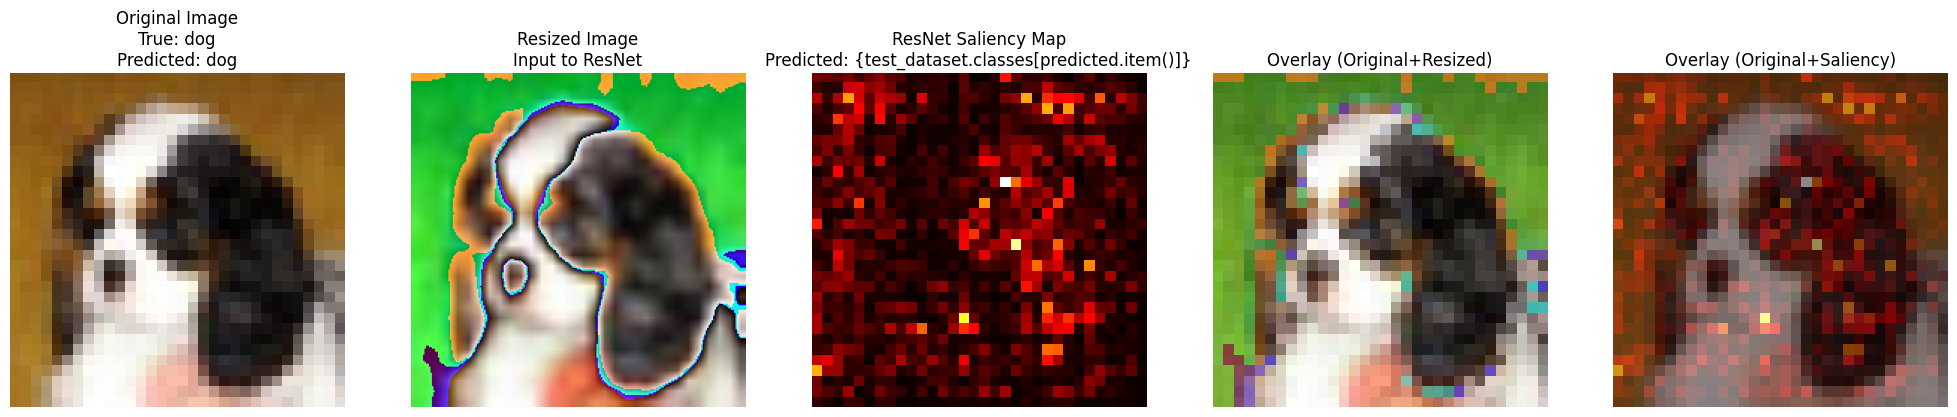

In [57]:
with torch.no_grad():
    random_index = random.randint(0, len(test_dataset) - 1)

    original_image, label = torchvision.datasets.CIFAR10(root='./data', train=False, download=False)[random_index]

    image, label = test_dataset[random_index]
    image_tensor = image.unsqueeze(0).to(device)
    output = model(image_tensor)

    # Debugging: Check Output Shape
    print(f"Model Output Shape: {output.shape}")

    # Debugging: Check for NaNs and Infs
    if torch.isnan(output).any() or torch.isinf(output).any():
        print("NaN or Inf values found in model output!")
        print(output)
        # Handle the error or investigate further.
        # you may want to return, or stop the code, or skip the image.

    _, predicted = torch.max(output, 1)

    # Debugging: Print Output, Predicted, and Max Logit
    print("Model Output:", output)
    print("Predicted Class:", predicted)
    print("Max Logit:", _)

image_tensor.requires_grad_(True)
model.zero_grad()
output_grad = model(image_tensor)
predicted_class = output_grad.argmax()
output_grad[0, predicted_class].backward()
saliency_map = image_tensor.grad.abs().sum(dim=1, keepdim=True)
saliency_map = saliency_map.squeeze().cpu().numpy()
saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

original_size = original_image.size
resized_saliency_map = cv2.resize(saliency_map, (original_size[0], original_size[1]))

fig, axes = plt.subplots(1, 5, figsize=(25, 5))

axes[0].imshow(original_image)
axes[0].set_title(f"Original Image\nTrue: {test_dataset.classes[label]}\nPredicted: {test_dataset.classes[predicted.item()]}")
axes[0].axis('off')

axes[1].imshow(torchvision.transforms.ToPILImage()(image))
axes[1].set_title("Resized Image\nInput to ResNet")
axes[1].axis('off')

axes[2].imshow(resized_saliency_map, cmap='hot')
axes[2].set_title("ResNet Saliency Map\nPredicted: {test_dataset.classes[predicted.item()]}")
axes[2].axis('off')

original_np = np.array(original_image) / 255.0
resized_np = np.array(torchvision.transforms.ToPILImage()(image)) / 255.0
resized_np = cv2.resize(resized_np, (original_np.shape[1], original_np.shape[0]))
overlay1 = cv2.addWeighted(original_np, 0.5, resized_np, 0.5, 0)
axes[3].imshow(overlay1)
axes[3].set_title("Overlay (Original+Resized)")
axes[3].axis('off')

axes[4].imshow(original_image)
axes[4].imshow(resized_saliency_map, cmap='hot', alpha=0.5)
axes[4].set_title("Overlay (Original+Saliency)")
axes[4].axis('off')

plt.show()

Accuracy of the network on the 10000 test images: 83.35 %


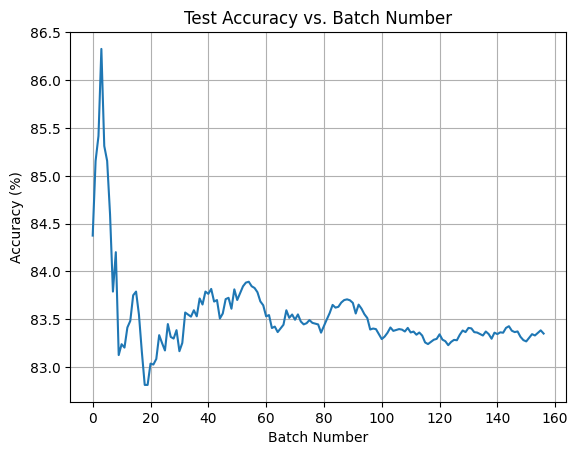

In [30]:
accuracies = []
batch_numbers = []

with torch.no_grad():
    correct = 0
    total = 0
    batch_num = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        batch_numbers.append(batch_num)
        batch_num += 1

    print(f'Accuracy of the network on the {len(test_dataset)} test images: {accuracy:.2f} %')

plt.plot(batch_numbers, accuracies)
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy vs. Batch Number')
plt.grid(True)
plt.show()